In [1]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM

In [2]:
df = pd.read_csv('/kaggle/input/dataset7/TrainingSet_3_Class.csv')
df.head()

,label,text
0,2,UPDATE: Rt. in York County has reopened near C...
1,0,#Fargo #ND #USA - Sr. Clinical Research Associ...
2,0,Just two of the biggest fans riding the ride i...
3,1,Wreck on Southbound just north of Atlanta High...
4,0,Justin bieber's new album is going to be amazi...


In [3]:
# text length
df['text_length'] = df['text'].apply(len)
df[['label','text']].head()

,label,text
0,2,UPDATE: Rt. in York County has reopened near C...
1,0,#Fargo #ND #USA - Sr. Clinical Research Associ...
2,0,Just two of the biggest fans riding the ride i...
3,1,Wreck on Southbound just north of Atlanta High...
4,0,Justin bieber's new album is going to be amazi...


In [4]:
import spacy
import string
import re

nlp = spacy.load('en_core_web_lg')

stopwords = _stop_words.ENGLISH_STOP_WORDS
lemmatizer = WordNetLemmatizer()

def clean(doc):
    text_no_namedentities = []
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
    doc = (" ".join(text_no_namedentities))

    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ") 
    doc = doc.replace("-", " ") 
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])    
    doc = "".join([lemmatizer.lemmatize(word) for word in doc])
    return doc

df['clean_tweet'] = df['text'].apply(clean)

text = df['clean_tweet'].to_string().lower()    

In [5]:
df.head()

,label,text,text_length,clean_tweet
0,2,UPDATE: Rt. in York County has reopened near C...,76,update york county reopened near commerce circ...
1,0,#Fargo #ND #USA - Sr. Clinical Research Associ...,115,fargo nd usa sr clinical research associate sr...
2,0,Just two of the biggest fans riding the ride i...,73,just biggest fans riding ride hi jimmy 👋 🏻
3,1,Wreck on Southbound just north of Atlanta High...,129,wreck southbound just north atlanta highway ex...
4,0,Justin bieber's new album is going to be amazi...,50,justin bieber s new album going amazing 🙌


In [6]:
# Encode Categorical Variable
X = df['clean_tweet']
y = pd.get_dummies(df['label']).values
num_classes = df['label'].nunique()

In [7]:
seed = 101
np.random.seed(seed)

In [8]:
# Split Train Test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40942,) (10236,) (40942, 3) (10236, 3)


In [9]:
# Tokenize Text
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

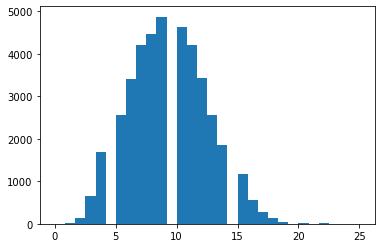

In [10]:
totalNumWords = [len(one_comment) for one_comment in X_train]
plt.hist(totalNumWords,bins = 30)
plt.show()

In [11]:
max_words = 150
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(40942, 150) (10236, 150)


In [12]:
batch_size = 128
epochs = 20

In [13]:
def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))    
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [14]:
def model_train(model):
    # train the model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)

In [15]:
def model_evaluate(): 
    cnn_loss, cnn_accuracy = model.evaluate(X_test, y_test)
    y_pred_cnn = model.predict(X_test)
    y_pred_cnn = (y_pred_cnn > 0.5).astype(int)
    cnn_mse = mean_squared_error(y_test, y_pred_cnn)

    print(f"CNN Accuracy: {cnn_accuracy}")
    print(f"CNN Loss: {cnn_loss}")
    print(f"CNN MSE: {cnn_mse}")

In [16]:
# train the model
max_features = 20000
embed_dim = 100
model = get_model(max_features, embed_dim)
model_train(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 150, 32)           9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 75, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 37, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 3)                 3

In [17]:
# evaluate model with test set
model_evaluate()

320/320 [==============================] - 4s 11ms/step - loss: 0.2313 - accuracy: 0.9637
CNN Accuracy: 0.9636576771736145
CNN Loss: 0.23129726946353912
CNN MSE: 0.02409795493031132
